# Predict Employee Burnout

## 1. Business Problem and Understanding

In [55]:
# Import libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import numpy as np
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer, make_column_selector
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, make_scorer, f1_score, ConfusionMatrixDisplay
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, \
GradientBoostingClassifier, VotingClassifier, StackingClassifier 
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImPipeline
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

## 2. Data Understanding

In [2]:
# Import data

train = pd.read_csv('Data/train.csv')
test = pd.read_csv('Data/test.csv')
sample_submission = pd.read_csv('Data/sample_submission.csv')

In [3]:
# Combine train & test

full_df = pd.concat([train,test],axis=0)
full_df.head()

,Employee ID,Date of Joining,Gender,Company Type,WFH Setup Available,Designation,Resource Allocation,Mental Fatigue Score,Burn Rate
0,fffe32003000360033003200,2008-09-30,Female,Service,No,2.0,3.0,3.8,0.16
1,fffe3700360033003500,2008-11-30,Male,Service,Yes,1.0,2.0,5.0,0.36
2,fffe31003300320037003900,2008-03-10,Female,Product,Yes,2.0,NaN,5.8,0.49
3,fffe32003400380032003900,2008-11-03,Male,Service,Yes,1.0,1.0,2.6,0.20
4,fffe31003900340031003600,2008-07-24,Female,Service,No,3.0,7.0,6.9,0.52


In [4]:
# Transform column names

full_df.columns = full_df.columns.str.lower()
full_df.columns = full_df.columns.str.replace(' ','_')

It looks like we have some missing values in the last 3 columns of the data set. With so much missing from the `burn_rate` we cannot drop those values, we would ideally impute on them.

In [5]:
full_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 35000 entries, 0 to 12249
Data columns (total 9 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   employee_id           35000 non-null  object 
 1   date_of_joining       35000 non-null  object 
 2   gender                35000 non-null  object 
 3   company_type          35000 non-null  object 
 4   wfh_setup_available   35000 non-null  object 
 5   designation           35000 non-null  float64
 6   resource_allocation   33619 non-null  float64
 7   mental_fatigue_score  32883 non-null  float64
 8   burn_rate             21626 non-null  float64
dtypes: float64(4), object(5)
memory usage: 2.7+ MB


In [6]:
full_df.isna().sum()/full_df.shape[0]*100

employee_id              0.000000
date_of_joining          0.000000
gender                   0.000000
company_type             0.000000
wfh_setup_available      0.000000
designation              0.000000
resource_allocation      3.945714
mental_fatigue_score     6.048571
burn_rate               38.211429
dtype: float64

We can see that all numeri columns are a scale, `burn_rate`, our target is from 0-1. We may want to adjust that to be on a 1-10 scale as the other variables

In [7]:
full_df.describe()

,designation,resource_allocation,mental_fatigue_score,burn_rate
count,35000.000000,33619.000000,32883.000000,21626.000000
mean,2.177514,4.473185,5.725350,0.452005
std,1.134339,2.046623,1.918292,0.198226
min,0.000000,1.000000,0.000000,0.000000
25%,1.000000,3.000000,4.500000,0.310000
50%,2.000000,4.000000,5.900000,0.450000
75%,3.000000,6.000000,7.100000,0.590000
max,5.000000,10.000000,10.000000,1.000000


## 3. Data Exporation

It looks like all of the columns with missingness are mostly normally distributed, so we can confidently impute with the mean.

mean: 0.45200545639508
median: 0.45


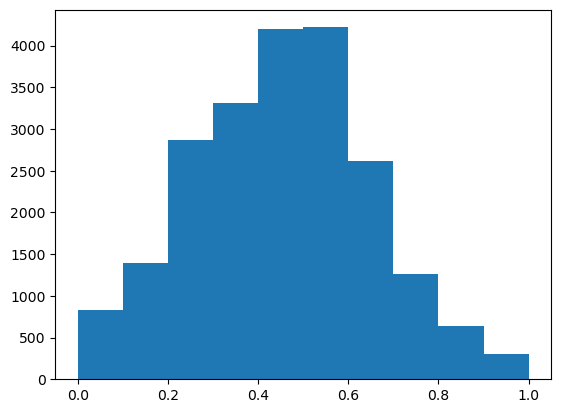

In [8]:
plt.hist(full_df['burn_rate']);

print('mean:',np.nanmean(full_df['burn_rate']))
print('median:',np.nanmedian(full_df['burn_rate']))

mean: 5.725350485053067
median: 5.9


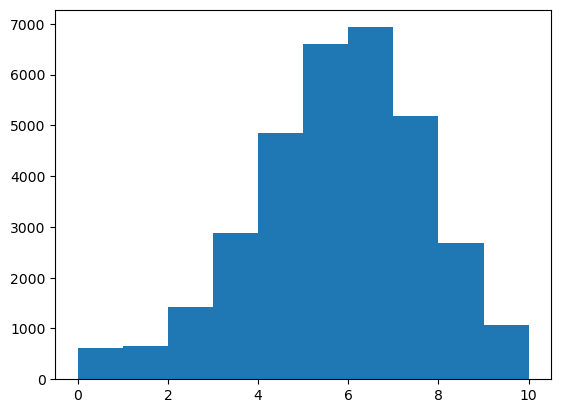

In [9]:
plt.hist(full_df['mental_fatigue_score']);

print('mean:',np.nanmean(full_df['mental_fatigue_score']))
print('median:',np.nanmedian(full_df['mental_fatigue_score']))

mean: 4.4731848062107735
median: 4.0


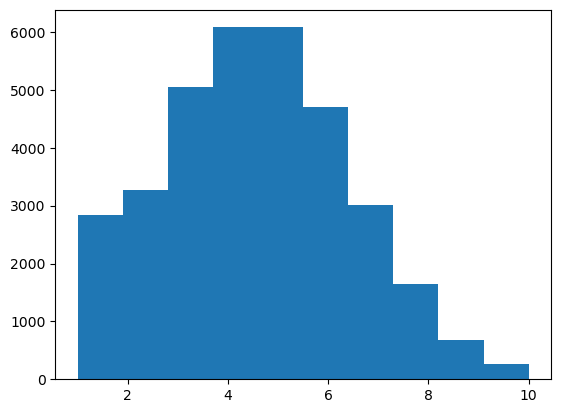

In [10]:
plt.hist(full_df['resource_allocation']);

print('mean:',np.nanmean(full_df['resource_allocation']))
print('median:',np.nanmedian(full_df['resource_allocation']))

We also don't have any duplicates so we can drop `employee_id` along with `date_of_joining` since we are working with one year.

In [11]:
full_df.duplicated(subset=['employee_id']).value_counts()

False    35000
Name: count, dtype: int64

### Target Variable `burn_rate`

Since we want to conduct a predictive model and better understand which employees are at risk of burnout, we will create a label column defining burnout. Since the metric was on a 0-1 scale, for ease of interpretation, we will increase this scale by 10 and round the number to the nearest whole number.

It looks like we have a slight class imbalance which we should try to address.

In [12]:
full_df['burn_label'] = full_df['burn_rate'].apply(lambda x: round(x*10) if not np.isnan(x) else x)
full_df['burn_label'].value_counts()

burn_label
4.0     4509
5.0     3697
6.0     3627
3.0     2848
2.0     2203
7.0     1826
8.0     1047
1.0      869
0.0      524
9.0      318
10.0     158
Name: count, dtype: int64

Unfortunately we have to drop the missing values in our target in order to split our data into train/test. This will reduce our dataset quite a bit but hopefully we can get decent results still.

In [13]:
print('Total size after dropping target nas:',full_df.shape[0])

print('Total missing values of target:',full_df['burn_label'].isna().sum())

y_nas_dropped = full_df.dropna(subset=['burn_label'])

print('Total size after dropping target nas:',y_nas_dropped.shape[0])

Total size after dropping target nas: 35000
Total missing values of target: 13374
Total size after dropping target nas: 21626


## 4. Data Preperation

In [14]:
# Define X, y and split train/test

X = y_nas_dropped.drop(columns=['date_of_joining','employee_id','burn_label','burn_rate'])
y = y_nas_dropped['burn_label']

X_train, X_test, y_train, y_test = train_test_split(X,y,random_state=42, stratify=y)
X_train.isna().sum()

gender                     0
company_type               0
wfh_setup_available        0
designation                0
resource_allocation      939
mental_fatigue_score    1504
dtype: int64

In [15]:
# Define num and cat subpipes
subpipe_num = Pipeline(steps=[('num_impute', SimpleImputer()),
                           ('ss', StandardScaler())])
subpipe_cat = Pipeline(steps=[('ohe', OneHotEncoder(sparse_output=False, handle_unknown='ignore'))])

# Create column transformer
CT = ColumnTransformer(transformers=[('subpipe_num', subpipe_num, [3, 4, 5]),
                                         ('subpipe_cat', subpipe_cat, [0, 1, 2])],
                           remainder='passthrough')
# Initial pipeline
logreg_pipe = Pipeline(steps=[('ct', CT),
                            ('model', LogisticRegression(random_state=42, max_iter=500))])
                            
logreg_pipe.fit(X_train, y_train)

Pipeline(steps=[('ct',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('subpipe_num',
                                                  Pipeline(steps=[('num_impute',
                                                                   SimpleImputer()),
                                                                  ('ss',
                                                                   StandardScaler())]),
                                                  [3, 4, 5]),
                                                 ('subpipe_cat',
                                                  Pipeline(steps=[('ohe',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  [0, 1, 2])])),
                ('model', LogisticRegression(max_iter=500, random_state=42))])

## 5. Logistic Regression Model

First, lets see if we can improve our LogisticRegression model.

In [17]:
# Define your parameter grid
params = {
    'model__C':[.0000001,.000001,.00001,.0001,.001,.01],
    'model__solver': ['lbfgs', 'liblinear', 'newton-cg'],
    'model__class_weight': [None,'balanced']
}

rcv=RandomizedSearchCV(logreg_pipe,param_distributions=params,scoring='f1_weighted',
                 return_train_score=True,cv=5,random_state=42,n_iter=15)

rcv.fit(X_train,y_train)
rcv.best_params_

{'model__solver': 'newton-cg',
 'model__class_weight': 'balanced',
 'model__C': 0.01}

We actually did worse after cross validation. It looks like our model isn't over/under fitting so that's a bonus. We may want to try a different type of model next.

In [18]:
# Create quick function to see the scores easier for future models
def rcv_metrics(rcv,model_name,X,y,train_df=None):
    best_estimator = rcv.best_estimator_
    y_pred = best_estimator.predict(X)
    score_dict = {'Val Train Score': np.mean(rcv.cv_results_['mean_train_score']),
                 'Val Test Score':np.mean(rcv.cv_results_['mean_test_score']),
                 'Model Name': model_name}
    score_df = pd.DataFrame(score_dict,columns=['Model Name','Val Train Score','Val Test Score'],
                            index=range(1))
    if train_df is None:
        pass
    else:
       score_df = pd.concat([train_df,score_df])
       score_df.index = range(len(score_df))
    return score_df, best_estimator
    
train_scores, logreg_best = rcv_metrics(rcv,'Logreg',X_train,y_train)
train_scores

,Model Name,Full Train Score,Val Train Score,Val Test Score
0,Logreg,0.417534,0.21326,0.211804


Our score on our test is around the same as on our train, so we know there is no overfitting or underfitting.

,Model Name,Train Score,Test Score
0,Logreg,0.417534,0.413424


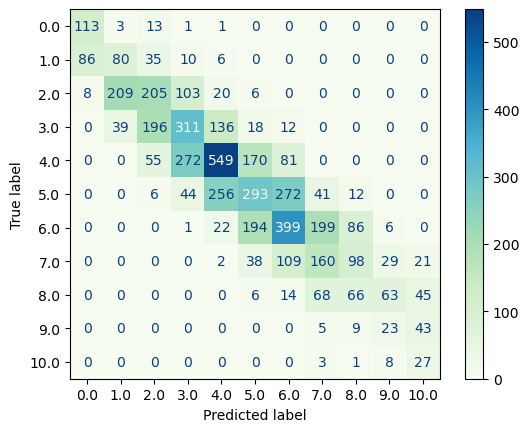

In [19]:
# Function to dislay f1 score and confusion matrix
def test_metrics(model,model_name,X,y,test_df=None):
    score_dict = {'Model Name':model_name,
                  'Train Score': f1_score(y_train,model.predict(X_train),average='weighted'),
                  'Test Score': f1_score(y, model.predict(X),average='weighted')}
    score_df=pd.DataFrame(score_dict,columns=['Model Name','Train Score','Test Score'],index=range(1))
    matrix = ConfusionMatrixDisplay.from_estimator(model,X,y,cmap='GnBu')
    if test_df is None:
        pass
    else:
       score_df = pd.concat([test_df,score_df])
       score_df.index = range(len(score_df))
       score_df.sort_values(by='Test Score')
    return score_df,matrix
    

# Predict on the test
test_scores, log_matrix = test_metrics(logreg_best,'Logreg',X_test,y_test)
display(test_scores)
log_matrix;

### `SMOTE` for Class Imbalance

Since we know we have a class imbalance, lets see how our model does if we incorporate `SMOTE` and balance out our target class, making sure to only resample all classes but the majority.

In [20]:
# Create new pipe with `SMOTE` and the a logisitic model with best parameters found with RandomizedCV

imb_pipe = ImPipeline(steps=[('ct',CT),
                            ('sm',SMOTE(random_state=42,sampling_strategy='not majority')),
                            ('model', LogisticRegression(random_state=42, max_iter=500))])

# Conduct new Randomized CV
params = {
    'model__C':[.0000001,.000001,.00001,.0001,.001,.01],
    'model__solver': ['lbfgs', 'liblinear', 'newton-cg'],
    'model__class_weight': [None,'balanced']
}

rcv=RandomizedSearchCV(imb_pipe,param_distributions=params,scoring='f1_weighted',
                 return_train_score=True,cv=5,random_state=42,n_iter=15)

rcv.fit(X_train,y_train)
rcv.best_params_

{'model__solver': 'newton-cg',
 'model__class_weight': 'balanced',
 'model__C': 0.01}

Looks like `SMOTE` decreased our scores, so we may want to stick to our weighted f1 score as the metric we focus on.

In [21]:
# Get train metrics
train_scores, logreg_sm = rcv_metrics(rcv,'Logreg Sm',X_train,y_train,train_scores)
train_scores

,Model Name,Full Train Score,Val Train Score,Val Test Score
0,Logreg,0.417534,0.213260,0.211804
1,Logreg Sm,0.433875,0.179295,0.177169


,Model Name,Train Score,Test Score
0,Logreg,0.417534,0.413424
1,Logreg sm,0.433875,0.436421


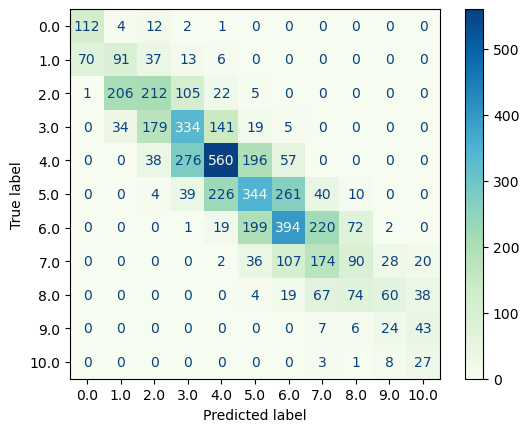

In [22]:
# Predict on the test
test_scores, log_matrix = test_metrics(logreg_sm,'Logreg sm',X_test,y_test,test_scores)
display(test_scores)
log_matrix;

## 6. DecisionTree Classifiers

Let's see if Decision Tree classifiers can improve our scores

### Decision Tree

Next we will try a simple Decision Tree to see if the bagging and subspace sampling can get us a more stable score between model and cross validation.

In [23]:
# Replace classifier in pipeline

dec_pipe = logreg_pipe.set_params(model=DecisionTreeClassifier(random_state=42))
dec_pipe.fit(X_train,y_train)

Pipeline(steps=[('ct',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('subpipe_num',
                                                  Pipeline(steps=[('num_impute',
                                                                   SimpleImputer()),
                                                                  ('ss',
                                                                   StandardScaler())]),
                                                  [3, 4, 5]),
                                                 ('subpipe_cat',
                                                  Pipeline(steps=[('ohe',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  [0, 1, 2])])),
                ('model', DecisionTreeClassifier(random_state=42))])

In [24]:
# Randomizedsearch CV 

params = {'model__criterion': ['gini','entropy','log_loss'],
          'model__max_depth': [3, 4, 5, 6, 7, 8, 9, 10],
          'model__min_samples_split': [2, 5, 10, 20, 50],
          'model__class_weight': [None,'balanced'],
          'model__min_samples_leaf': [1, 2, 5, 10]
}

rcv = RandomizedSearchCV(dec_pipe,param_distributions=params,scoring='f1_weighted',
                        return_train_score=True,random_state=42,n_iter=15)

rcv.fit(X_train,y_train)
rcv.best_params_

{'model__min_samples_split': 5,
 'model__min_samples_leaf': 2,
 'model__max_depth': 7,
 'model__criterion': 'gini',
 'model__class_weight': None}

Looks like both, full training score and both validation scores are better than the Logistic Regression model.

In [25]:
# Get train metrics
train_scores, dec_best = rcv_metrics(rcv,'Decision',X_train,y_train,train_scores)
train_scores

,Model Name,Full Train Score,Val Train Score,Val Test Score
0,Logreg,0.417534,0.213260,0.211804
1,Logreg Sm,0.433875,0.179295,0.177169
2,Decision,0.554677,0.513247,0.492566


We wee our test score is once again around the same as our train, and we did a lot better than the Logistic Regression model.

,Model Name,Train Score,Test Score
0,Logreg,0.417534,0.413424
1,Logreg sm,0.433875,0.436421
2,Decision,0.554677,0.546730


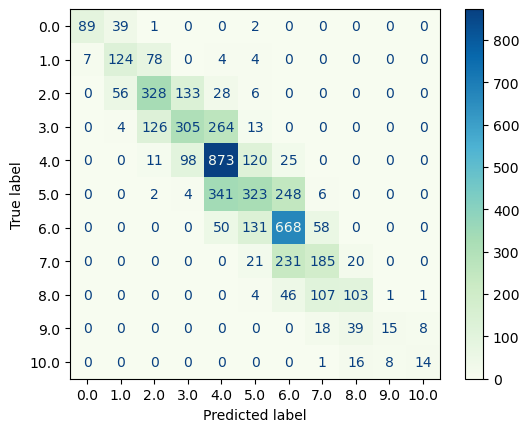

In [26]:
# Predict on the test
test_scores, log_matrix = test_metrics(dec_best,'Decision',X_test,y_test,test_scores)
display(test_scores)
log_matrix;

### Random Forest

Since Random Forests are better at addressing overfitting, we will try to see if we can improve our model with this ensemble model.

In [27]:
# Replace classifier in pipeline

forest_pipe = logreg_pipe.set_params(model=RandomForestClassifier(random_state=42))
forest_pipe.fit(X_train,y_train)

Pipeline(steps=[('ct',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('subpipe_num',
                                                  Pipeline(steps=[('num_impute',
                                                                   SimpleImputer()),
                                                                  ('ss',
                                                                   StandardScaler())]),
                                                  [3, 4, 5]),
                                                 ('subpipe_cat',
                                                  Pipeline(steps=[('ohe',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  [0, 1, 2])])),
                ('model', RandomForestClassifier(random_state=42))])

In [28]:
# Randomizedsearch CV 

params = {'model__criterion': ['gini','entropy','log_loss'],
          'model__max_depth': [3, 4, 5, 6, 7, 8, 9, 10],
          'model__min_samples_split': [2, 5, 10, 20, 50],
          'model__class_weight': ['balanced_subsample','balanced'],
          'model__max_features': ['sqrt','log2',None],
          'model__min_samples_leaf': [1, 2, 5, 10]
}

rcv = RandomizedSearchCV(forest_pipe,param_distributions=params,scoring='f1_weighted',
                        return_train_score=True,random_state=42,n_iter=15)

rcv.fit(X_train,y_train)
rcv.best_params_

{'model__min_samples_split': 5,
 'model__min_samples_leaf': 2,
 'model__max_features': None,
 'model__max_depth': 10,
 'model__criterion': 'gini',
 'model__class_weight': 'balanced_subsample'}

In [29]:
train_scores, rf_best = rcv_metrics(rcv,'Rand Forest',X_train,y_train,train_scores)
train_scores

,Model Name,Full Train Score,Val Train Score,Val Test Score
0,Logreg,0.417534,0.213260,0.211804
1,Logreg Sm,0.433875,0.179295,0.177169
2,Decision,0.554677,0.513247,0.492566
3,Rand Forest,0.587206,0.530268,0.501302


Our test score is around the same as for our Decision Tree but there is a bit of overfitting as our train score is a bit higher than our test.

,Model Name,Train Score,Test Score
0,Logreg,0.417534,0.413424
1,Logreg sm,0.433875,0.436421
2,Decision,0.554677,0.546730
3,Rand Forest,0.587206,0.533848


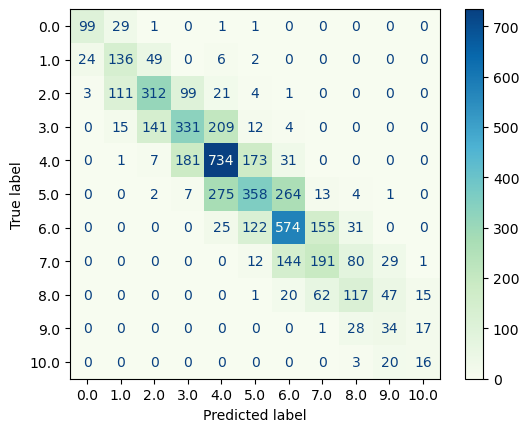

In [30]:
# Predict on the test
test_scores, log_matrix = test_metrics(rf_best,'Rand Forest',X_test,y_test,test_scores)
display(test_scores)
log_matrix;

## 7. Boosting Classifiers

Lets see boosting classifiers yeild better results, starting with `AdaBoostingClassifier` first.

### AdaBoost

Our score before cross validation is even smaller than before.

In [31]:
# Replace classifier in pipeline

ada_pipe = logreg_pipe.set_params(model=AdaBoostClassifier(random_state=42,algorithm='SAMME'))
ada_pipe.fit(X_train,y_train)

Pipeline(steps=[('ct',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('subpipe_num',
                                                  Pipeline(steps=[('num_impute',
                                                                   SimpleImputer()),
                                                                  ('ss',
                                                                   StandardScaler())]),
                                                  [3, 4, 5]),
                                                 ('subpipe_cat',
                                                  Pipeline(steps=[('ohe',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  [0, 1, 2])])),
                ('model',
                 AdaBoostClassifier(algorithm='SAMME', random_state=42))])

In [32]:
# Randomizedsearch CV 

params = {'model__learning_rate': [0.01, 0.05, 0.1, 0.2, 0.3],
          'model__n_estimators': [50, 100, 200, 500, 1000]
}

rcv = RandomizedSearchCV(ada_pipe,param_distributions=params,scoring='f1_weighted',
                        return_train_score=True,random_state=42,n_iter=15)

rcv.fit(X_train,y_train)
rcv.best_params_

{'model__n_estimators': 500, 'model__learning_rate': 0.3}

Adaboost is doing worse than our Decision Tree models which so far is performing the best out of all of the models we have tried

In [33]:
train_scores, ada_best = rcv_metrics(rcv,'AdaBoost',X_train,y_train,train_scores)
train_scores

,Model Name,Full Train Score,Val Train Score,Val Test Score
0,Logreg,0.417534,0.213260,0.211804
1,Logreg Sm,0.433875,0.179295,0.177169
2,Decision,0.554677,0.513247,0.492566
3,Rand Forest,0.587206,0.530268,0.501302
4,AdaBoost,0.397551,0.274923,0.273458


We are now slighly underfitting but not by much. We will see if we can improve this with other boosting algorithms. There is no over fitting or underfitting as the train and test are nearly the same.

,Model Name,Train Score,Test Score
0,Logreg,0.417534,0.413424
1,Logreg sm,0.433875,0.436421
2,Decision,0.554677,0.546730
3,Rand Forest,0.587206,0.533848
4,AdaBoost,0.397551,0.404987


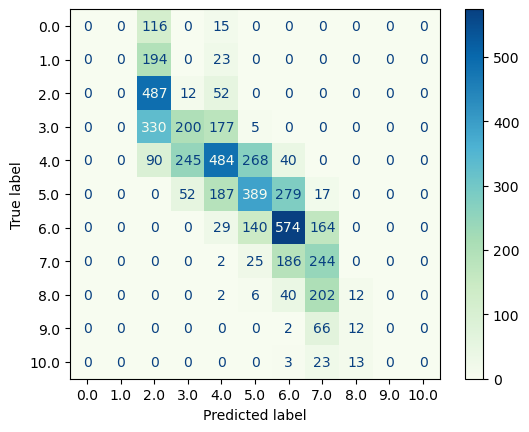

In [34]:
# Predict on the test
test_scores, log_matrix = test_metrics(ada_best,'AdaBoost',X_test,y_test,test_scores)
display(test_scores)
log_matrix;

### GradientBoost

In [35]:
# Replace classifier in pipeline

gradient_pipe = logreg_pipe.set_params(model=GradientBoostingClassifier(random_state=42))
gradient_pipe.fit(X_train,y_train)

Pipeline(steps=[('ct',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('subpipe_num',
                                                  Pipeline(steps=[('num_impute',
                                                                   SimpleImputer()),
                                                                  ('ss',
                                                                   StandardScaler())]),
                                                  [3, 4, 5]),
                                                 ('subpipe_cat',
                                                  Pipeline(steps=[('ohe',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  [0, 1, 2])])),
                ('model', GradientBoostingClassifier(random_state=42))])

We will set verbose to 3 so that we can confirm the code is running as this CV takes a bit for the boosting algorithms to run when there are this many hyperparameters to tune.

In [36]:
# Randomizedsearch CV 

params_gb = {'model__max_depth': [3, 4, 6, 8, 10],
          'model__learning_rate': [0.01, 0.05, 0.1, 0.2, 0.3],
          'model__n_estimators': [100, 200, 500, 1000],
          'model__min_samples_split':  [2, 5, 10, 20, 50],
          'model__max_features': ['sqrt','log2',None],
          'model__subsample': [0.5, 0.75, 1.0],
          'model__min_samples_leaf': [1, 2, 5, 10]
          
}

rcv_gb = RandomizedSearchCV(gradient_pipe,param_distributions=params_gb,scoring='f1_weighted',
                        return_train_score=True,random_state=42,n_iter=10,verbose=3)

rcv_gb.fit(X_train,y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV 1/5] END model__learning_rate=0.3, model__max_depth=4, model__max_features=None, model__min_samples_leaf=10, model__min_samples_split=5, model__n_estimators=200, model__subsample=0.5;, score=(train=0.614, test=0.517) total time=   8.6s
[CV 2/5] END model__learning_rate=0.3, model__max_depth=4, model__max_features=None, model__min_samples_leaf=10, model__min_samples_split=5, model__n_estimators=200, model__subsample=0.5;, score=(train=0.607, test=0.504) total time=   8.6s
[CV 3/5] END model__learning_rate=0.3, model__max_depth=4, model__max_features=None, model__min_samples_leaf=10, model__min_samples_split=5, model__n_estimators=200, model__subsample=0.5;, score=(train=0.577, test=0.510) total time=   8.6s
[CV 4/5] END model__learning_rate=0.3, model__max_depth=4, model__max_features=None, model__min_samples_leaf=10, model__min_samples_split=5, model__n_estimators=200, model__subsample=0.5;, score=(train=0.611, test=0.506

RandomizedSearchCV(estimator=Pipeline(steps=[('ct',
                                              ColumnTransformer(remainder='passthrough',
                                                                transformers=[('subpipe_num',
                                                                               Pipeline(steps=[('num_impute',
                                                                                                SimpleImputer()),
                                                                                               ('ss',
                                                                                                StandardScaler())]),
                                                                               [3,
                                                                                4,
                                                                                5]),
                                                                              ('subpipe_cat',
                                                                               Pipeline(steps=[('ohe',
                                                                                                OneHotEncoder(handle_unknown='ignore',
                                                                                                              sparse_output=False))]),
                                                                               [0,
                                                                                1,
                                                                                2])])),
                                             ('model',
                                              GradientBoostingClassifie...
                   param_distributions={'model__learning_rate': [0.01, 0.05,
                                                                 0.1, 0.2,
                                                                 0.3],
                                        'model__max_depth': [3, 4, 6, 8, 10],
                                        'model__max_features': ['sqrt', 'log2',
                                                                None],
                                        'model__min_samples_leaf': [1, 2, 5,
                                                                    10],
                                        'model__min_samples_split': [2, 5, 10,
                                                                     20, 50],
                                        'model__n_estimators': [100, 200, 500,
                                                                1000],
                                        'model__subsample': [0.5, 0.75, 1.0]},
                   random_state=42, return_train_score=True,
                   scoring='f1_weighted', verbose=3)

In [37]:
# Print parameters of best estimate
rcv_gb.best_params_

{'model__subsample': 1.0,
 'model__n_estimators': 500,
 'model__min_samples_split': 5,
 'model__min_samples_leaf': 5,
 'model__max_features': 'sqrt',
 'model__max_depth': 4,
 'model__learning_rate': 0.01}

Our Gradient Boost did about as well as our Decision Tree algorithms. So far, we would want to use these three in other ensemble models to try to get these scores to a good place.

In [38]:
# Get best train scores
train_scores, gradient_best = rcv_metrics(rcv_gb,'GradientBoost',X_train,y_train,train_scores)
train_scores

,Model Name,Full Train Score,Val Train Score,Val Test Score
0,Logreg,0.417534,0.213260,0.211804
1,Logreg Sm,0.433875,0.179295,0.177169
2,Decision,0.554677,0.513247,0.492566
3,Rand Forest,0.587206,0.530268,0.501302
4,AdaBoost,0.397551,0.274923,0.273458
5,GradientBoost,0.576951,0.520089,0.448505


There is slight overfitting but not as much as in our validation data. 

,Model Name,Train Score,Test Score
0,Logreg,0.417534,0.413424
1,Logreg sm,0.433875,0.436421
2,Decision,0.554677,0.546730
3,Rand Forest,0.587206,0.533848
4,AdaBoost,0.397551,0.404987
5,GradientBoost,0.576951,0.552904


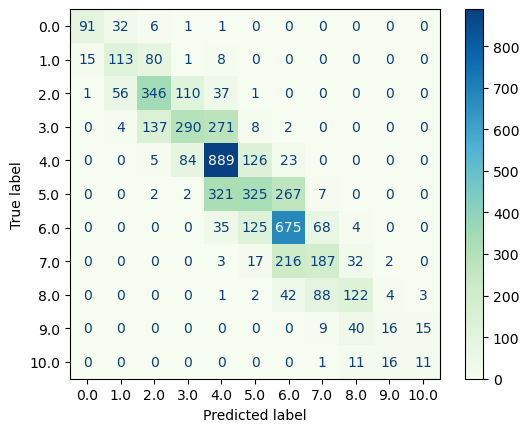

In [39]:
# Predict on the test
test_scores, log_matrix = test_metrics(gradient_best,'GradientBoost',X_test,y_test,test_scores)
display(test_scores)
log_matrix;

### XGBoost

The last boosting algorithm we will try is XGBoost, it is great for classification problems.

In [40]:
# Replace classifier in pipeline

xgboost_pipe = logreg_pipe.set_params(model=XGBClassifier(random_state=42))
xgboost_pipe.fit(X_train,y_train)

Pipeline(steps=[('ct',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('subpipe_num',
                                                  Pipeline(steps=[('num_impute',
                                                                   SimpleImputer()),
                                                                  ('ss',
                                                                   StandardScaler())]),
                                                  [3, 4, 5]),
                                                 ('subpipe_cat',
                                                  Pipeline(steps=[('ohe',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  [0, 1, 2])])),
                ('model',
                 XGBClassifier(base_score=None, booster=None, callbacks=N...
                               feature_types=None, gamma=None, grow_policy=None,
                               importance_type=None,
                               interaction_constraints=None, learning_rate=None,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=None, max_leaves=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, multi_strategy=None,
                               n_estimators=None, n_jobs=None,
                               num_parallel_tree=None,
                               objective='multi:softprob', ...))])

In [41]:
# Randomizedsearch CV 

params_xgb = {'model__learning_rate':  [0.01, 0.05, 0.1, 0.3, 0.5],
          'model__n_estimators': [100, 500, 1000, 2000, 3000],
          'model__min_child_weight':  [1,5,10,20,50],
          'model__colsample_bytree': [0.5, 0.75, 1.0],
          'model__subsample': [0.5, 0.75, 1.0],
          'model__gamma': [0, 0.1, 0.2, 0.3, 0.4, 0.5],
          'model__reg_alpha':  [0, 0.001, 0.01, 0.1, 1, 10],
          'model__reg_lambda':  [0, 0.001, 0.01, 0.1, 1, 10],
          'model__max_depth': [3, 4, 5, 6, 7, 8, 9, 10]
}

rcv_xgb = RandomizedSearchCV(xgboost_pipe,param_distributions=params_xgb,scoring='f1_weighted',
                        return_train_score=True,random_state=42,n_iter=10,verbose=3)

rcv_xgb.fit(X_train,y_train)
rcv_xgb.best_params_

Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV 1/5] END model__colsample_bytree=0.5, model__gamma=0.1, model__learning_rate=0.01, model__max_depth=8, model__min_child_weight=1, model__n_estimators=3000, model__reg_alpha=0.001, model__reg_lambda=0.01, model__subsample=1.0;, score=(train=0.605, test=0.543) total time=  15.8s
[CV 2/5] END model__colsample_bytree=0.5, model__gamma=0.1, model__learning_rate=0.01, model__max_depth=8, model__min_child_weight=1, model__n_estimators=3000, model__reg_alpha=0.001, model__reg_lambda=0.01, model__subsample=1.0;, score=(train=0.605, test=0.544) total time=  18.0s
[CV 3/5] END model__colsample_bytree=0.5, model__gamma=0.1, model__learning_rate=0.01, model__max_depth=8, model__min_child_weight=1, model__n_estimators=3000, model__reg_alpha=0.001, model__reg_lambda=0.01, model__subsample=1.0;, score=(train=0.604, test=0.548) total time=  23.7s
[CV 4/5] END model__colsample_bytree=0.5, model__gamma=0.1, model__learning_rate=0.01, model_

{'model__subsample': 1.0,
 'model__reg_lambda': 1,
 'model__reg_alpha': 1,
 'model__n_estimators': 3000,
 'model__min_child_weight': 50,
 'model__max_depth': 10,
 'model__learning_rate': 0.05,
 'model__gamma': 0.2,
 'model__colsample_bytree': 0.5}

In [42]:
# Print parameters of the best estimator
rcv_xgb.best_params_

{'model__subsample': 1.0,
 'model__reg_lambda': 1,
 'model__reg_alpha': 1,
 'model__n_estimators': 3000,
 'model__min_child_weight': 50,
 'model__max_depth': 10,
 'model__learning_rate': 0.05,
 'model__gamma': 0.2,
 'model__colsample_bytree': 0.5}

Very similar results as our Gradient Boost, our validation scores are slightly higher so this model might have a bit more variance. This model is also overfitting more than the previous boosting algorithms.

In [43]:
# Get best train scores
train_scores, xgboost_best = rcv_metrics(rcv_xgb,'XGBoost',X_train,y_train,train_scores)
train_scores

,Model Name,Full Train Score,Val Train Score,Val Test Score
0,Logreg,0.417534,0.213260,0.211804
1,Logreg Sm,0.433875,0.179295,0.177169
2,Decision,0.554677,0.513247,0.492566
3,Rand Forest,0.587206,0.530268,0.501302
4,AdaBoost,0.397551,0.274923,0.273458
5,GradientBoost,0.576951,0.520089,0.448505
6,XGBoost,0.573877,0.586083,0.536794


,Model Name,Train Score,Test Score
0,Logreg,0.417534,0.413424
1,Logreg sm,0.433875,0.436421
2,Decision,0.554677,0.546730
3,Rand Forest,0.587206,0.533848
4,AdaBoost,0.397551,0.404987
5,GradientBoost,0.576951,0.552904
6,XGBoost,0.573877,0.555255


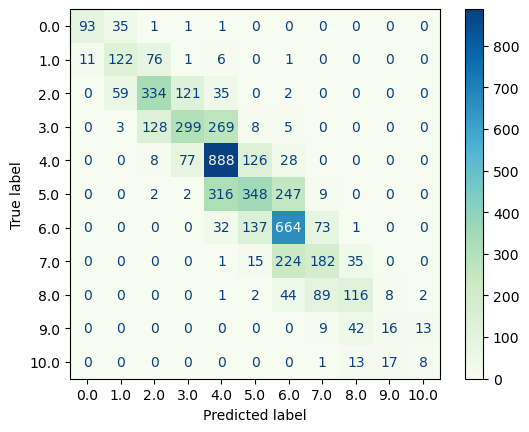

In [44]:
# Predict on the test
test_scores, log_matrix = test_metrics(xgboost_best,'XGBoost',X_test,y_test,test_scores)
display(test_scores)
log_matrix;

## 8. Averaging & Weighted Avereging

Lastly, we will take some of our best models and create combined models to see if we can get the best out of all of them.

### VotingClassifier

In [45]:
# Create weighted averaging 

estimators = [
    ('dt',dec_best),
    ('rf',rf_best),
    ('gb',gradient_best),
    ('xgb',xgboost_best)
]

w_avg_pipe = logreg_pipe.set_params(model=VotingClassifier(estimators=estimators, weights=[.15,.15,.20,.50]))

w_avg_pipe.fit(X_train,y_train)

Pipeline(steps=[('ct',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('subpipe_num',
                                                  Pipeline(steps=[('num_impute',
                                                                   SimpleImputer()),
                                                                  ('ss',
                                                                   StandardScaler())]),
                                                  [3, 4, 5]),
                                                 ('subpipe_cat',
                                                  Pipeline(steps=[('ohe',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  [0, 1, 2])])),
                ('model',
                 VotingClassifier(estimators=[('dt',
                                               Pipeline(steps=[('c...
                                                                              interaction_constraints=None,
                                                                              learning_rate=0.05,
                                                                              max_bin=None,
                                                                              max_cat_threshold=None,
                                                                              max_cat_to_onehot=None,
                                                                              max_delta_step=None,
                                                                              max_depth=10,
                                                                              max_leaves=None,
                                                                              min_child_weight=50,
                                                                              missing=nan,
                                                                              monotone_constraints=None,
                                                                              multi_strategy=None,
                                                                              n_estimators=3000,
                                                                              n_jobs=None,
                                                                              num_parallel_tree=None,
                                                                              objective='multi:softprob', ...))]))],
                                  weights=[0.15, 0.15, 0.2, 0.5]))])

In [46]:
# Randomizedsearch CV 

params_w_avg = {'model__voting': ['hard','soft']
}

rcv_w_avg = RandomizedSearchCV(w_avg_pipe,param_distributions=params_w_avg,scoring='f1_weighted',
                        return_train_score=True,random_state=42,n_iter=2,verbose=3)

rcv_w_avg.fit(X_train,y_train)

Fitting 5 folds for each of 2 candidates, totalling 10 fits
[CV 1/5] END model__voting=hard;, score=(train=0.506, test=0.474) total time=  59.8s
[CV 2/5] END model__voting=hard;, score=(train=0.501, test=0.480) total time=  55.4s
[CV 3/5] END model__voting=hard;, score=(train=0.508, test=0.475) total time=  56.9s
[CV 4/5] END model__voting=hard;, score=(train=0.507, test=0.466) total time=  56.8s
[CV 5/5] END model__voting=hard;, score=(train=0.503, test=0.483) total time=  57.4s
[CV 1/5] END model__voting=soft;, score=(train=0.541, test=0.492) total time=  56.6s
[CV 2/5] END model__voting=soft;, score=(train=0.542, test=0.501) total time=  58.0s
[CV 3/5] END model__voting=soft;, score=(train=0.544, test=0.512) total time=  56.7s
[CV 4/5] END model__voting=soft;, score=(train=0.544, test=0.496) total time=  59.2s
[CV 5/5] END model__voting=soft;, score=(train=0.544, test=0.519) total time=  55.2s


RandomizedSearchCV(estimator=Pipeline(steps=[('ct',
                                              ColumnTransformer(remainder='passthrough',
                                                                transformers=[('subpipe_num',
                                                                               Pipeline(steps=[('num_impute',
                                                                                                SimpleImputer()),
                                                                                               ('ss',
                                                                                                StandardScaler())]),
                                                                               [3,
                                                                                4,
                                                                                5]),
                                                                              ('subpipe_cat',
                                                                               Pipeline(steps=[('ohe',
                                                                                                OneHotEncoder(handle_unknown='ignore',
                                                                                                              sparse_output=False))]),
                                                                               [0,
                                                                                1,
                                                                                2])])),
                                             ('model',
                                              VotingClassifier(estimato...
                                                                                                           max_leaves=None,
                                                                                                           min_child_weight=50,
                                                                                                           missing=nan,
                                                                                                           monotone_constraints=None,
                                                                                                           multi_strategy=None,
                                                                                                           n_estimators=3000,
                                                                                                           n_jobs=None,
                                                                                                           num_parallel_tree=None,
                                                                                                           objective='multi:softprob', ...))]))],
                                                               weights=[0.15,
                                                                        0.15,
                                                                        0.2,
                                                                        0.5]))]),
                   n_iter=2,
                   param_distributions={'model__voting': ['hard', 'soft']},
                   random_state=42, return_train_score=True,
                   scoring='f1_weighted', verbose=3)

In [47]:
# Print parameters of the beast estimator
rcv_w_avg.best_params_

{'model__voting': 'soft'}

Our Voting Classifier did slightly worse than our GradientBoost and XGBoost and is overfitting slightly more.

In [48]:
# Get best train scores
train_scores, w_avg_best = rcv_metrics(rcv_w_avg,'Voting',X_train,y_train,train_scores)
train_scores

,Model Name,Full Train Score,Val Train Score,Val Test Score
0,Logreg,0.417534,0.213260,0.211804
1,Logreg Sm,0.433875,0.179295,0.177169
2,Decision,0.554677,0.513247,0.492566
3,Rand Forest,0.587206,0.530268,0.501302
4,AdaBoost,0.397551,0.274923,0.273458
5,GradientBoost,0.576951,0.520089,0.448505
6,XGBoost,0.573877,0.586083,0.536794
7,Voting,0.555283,0.523977,0.489642


,Model Name,Train Score,Test Score
0,Logreg,0.417534,0.413424
1,Logreg sm,0.433875,0.436421
2,Decision,0.554677,0.546730
3,Rand Forest,0.587206,0.533848
4,AdaBoost,0.397551,0.404987
5,GradientBoost,0.576951,0.552904
6,XGBoost,0.573877,0.555255
7,Voting,0.555283,0.520349


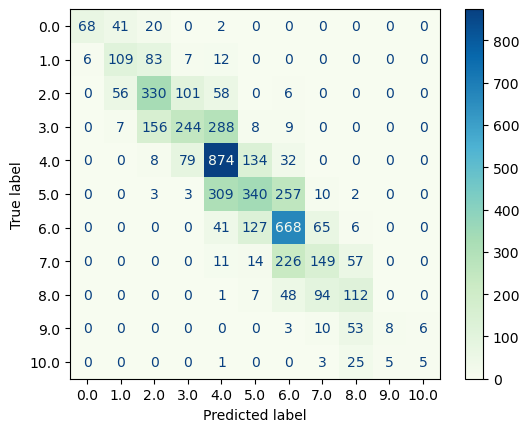

In [49]:
# Predict on the test
test_scores, log_matrix = test_metrics(w_avg_best,'Voting',X_test,y_test,test_scores)
display(test_scores)
log_matrix;

### StackingClassifier

In [50]:
# replace in pipe

estimators = [
    ('dt',dec_best),
    ('rf',rf_best),
    ('gb',gradient_best),
    ('xgb',xgboost_best)
]

stacking_pipe = logreg_pipe.set_params(model=StackingClassifier(estimators=estimators))

stacking_pipe.fit(X_train,y_train)

/Users/elinarankova/anaconda3/envs/learn-env-lite-2/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Pipeline(steps=[('ct',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('subpipe_num',
                                                  Pipeline(steps=[('num_impute',
                                                                   SimpleImputer()),
                                                                  ('ss',
                                                                   StandardScaler())]),
                                                  [3, 4, 5]),
                                                 ('subpipe_cat',
                                                  Pipeline(steps=[('ohe',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  [0, 1, 2])])),
                ('model',
                 StackingClassifier(estimators=[('dt',
                                                 Pipeline(steps=[(...
                                                                                grow_policy=None,
                                                                                importance_type=None,
                                                                                interaction_constraints=None,
                                                                                learning_rate=0.05,
                                                                                max_bin=None,
                                                                                max_cat_threshold=None,
                                                                                max_cat_to_onehot=None,
                                                                                max_delta_step=None,
                                                                                max_depth=10,
                                                                                max_leaves=None,
                                                                                min_child_weight=50,
                                                                                missing=nan,
                                                                                monotone_constraints=None,
                                                                                multi_strategy=None,
                                                                                n_estimators=3000,
                                                                                n_jobs=None,
                                                                                num_parallel_tree=None,
                                                                                objective='multi:softprob', ...))]))]))])

In [51]:
# Randomizedsearch CV 

params_stacking = {'model__stack_method': ['auto', 'predict_proba', 'decision_function', 'predict'],
                   'model__final_estimator': [XGBClassifier(),GradientBoostingClassifier()]
}

rcv_stacking = RandomizedSearchCV(stacking_pipe,param_distributions=params_stacking,scoring='f1_weighted',
                        return_train_score=True,random_state=42,n_iter=2,verbose=3)

rcv_stacking.fit(X_train,y_train)

Fitting 5 folds for each of 2 candidates, totalling 10 fits
[CV 1/5] END model__final_estimator=XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...), model__stack_method=predict_proba;, score=(train=0.570, test=0.521) total time= 4.3min
[CV 2/5] END model__final_estimator=XGBClassifier(base_sco

RandomizedSearchCV(estimator=Pipeline(steps=[('ct',
                                              ColumnTransformer(remainder='passthrough',
                                                                transformers=[('subpipe_num',
                                                                               Pipeline(steps=[('num_impute',
                                                                                                SimpleImputer()),
                                                                                               ('ss',
                                                                                                StandardScaler())]),
                                                                               [3,
                                                                                4,
                                                                                5]),
                                                                              ('subpipe_cat',
                                                                               Pipeline(steps=[('ohe',
                                                                                                OneHotEncoder(handle_unknown='ignore',
                                                                                                              sparse_output=False))]),
                                                                               [0,
                                                                                1,
                                                                                2])])),
                                             ('model',
                                              StackingClassifier(estima...
                                                                                 max_leaves=None,
                                                                                 min_child_weight=None,
                                                                                 missing=nan,
                                                                                 monotone_constraints=None,
                                                                                 multi_strategy=None,
                                                                                 n_estimators=None,
                                                                                 n_jobs=None,
                                                                                 num_parallel_tree=None,
                                                                                 random_state=None, ...),
                                                                   GradientBoostingClassifier()],
                                        'model__stack_method': ['auto',
                                                                'predict_proba',
                                                                'decision_function',
                                                                'predict']},
                   random_state=42, return_train_score=True,
                   scoring='f1_weighted', verbose=3)

In [52]:
# Print parameters of the beast estimator
rcv_stacking.best_params_

{'model__stack_method': 'predict_proba',
 'model__final_estimator': GradientBoostingClassifier()}

Looks like Stacking gives us around the same results as Voting! It is also overfitting on the validation data.

In [53]:
# Get best validation scores
train_scores, stacking_best = rcv_metrics(rcv_stacking,'Stacking',X_train,y_train,train_scores)
train_scores

,Model Name,Full Train Score,Val Train Score,Val Test Score
0,Logreg,0.417534,0.213260,0.211804
1,Logreg Sm,0.433875,0.179295,0.177169
2,Decision,0.554677,0.513247,0.492566
3,Rand Forest,0.587206,0.530268,0.501302
4,AdaBoost,0.397551,0.274923,0.273458
5,GradientBoost,0.576951,0.520089,0.448505
6,XGBoost,0.573877,0.586083,0.536794
7,Voting,0.555283,0.523977,0.489642
8,Stacking,0.552199,0.560828,0.515608


Looking at our train vs test scores, we are still getting the best result swith GradientBoost and XGBoost.

,Model Name,Train Score,Test Score
0,Logreg,0.417534,0.413424
1,Logreg sm,0.433875,0.436421
2,Decision,0.554677,0.546730
3,Rand Forest,0.587206,0.533848
4,AdaBoost,0.397551,0.404987
5,GradientBoost,0.576951,0.552904
6,XGBoost,0.573877,0.555255
7,Voting,0.555283,0.520349
8,Stacking,0.552199,0.535975


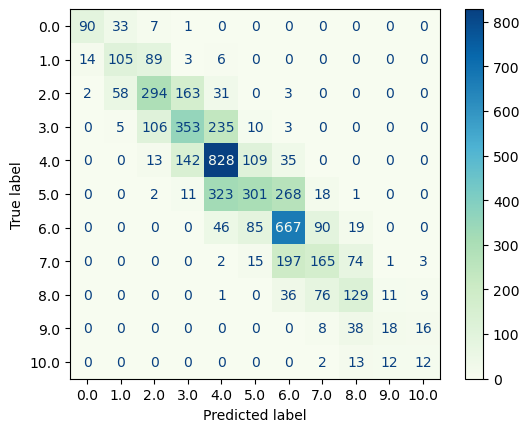

In [54]:
# Predict on the test
test_scores, log_matrix = test_metrics(stacking_best,'Stacking',X_test,y_test,test_scores)
display(test_scores)
log_matrix;